In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, zero_one_loss, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot
from imblearn.under_sampling import NearMiss
from collections import Counter

import sys
import time
import random
from scipy.stats import uniform, truncnorm, randint
from imblearn.under_sampling import NearMiss

from numpy.random import seed

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# function to reset all RNG's to seed 23
def reset_random_seeds():
   tf.random.set_seed(23) # tensorflow's seed
   np.random.seed(23) # numpy's seed
   random.seed(23) # python's seed

In [3]:
# import data
data = pd.read_csv (r'bank-additional\bank-additional.csv', sep = ';', engine= 'python')
#data = data.head(1000)
length = data.shape[0]
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [4]:
# select variables
cats_to_use = ['age', 'default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

In [5]:
# save lists of categorical and numerical variables
cat_cols = ['default', 'contact', 'month', 'poutcome', 'y']
num_cols = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']

# create column transformer to 1 one-hot-encode cat vars and 2 noralise num vars
ct = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_cols), # drop first column (reference)
    (StandardScaler(), num_cols),
)

# transform base table (pandas df -> numpy array)
base = ct.fit_transform(data)

# convert base table to p.df for ease of use (numpy array -> pandas df)
base_temp = pd.DataFrame(base, columns=ct.get_feature_names_out().tolist())
base_temp

,onehotencoder__default_unknown,onehotencoder__default_yes,onehotencoder__contact_telephone,onehotencoder__month_aug,onehotencoder__month_dec,onehotencoder__month_jul,onehotencoder__month_jun,onehotencoder__month_mar,onehotencoder__month_may,onehotencoder__month_nov,onehotencoder__month_oct,onehotencoder__month_sep,onehotencoder__poutcome_nonexistent,onehotencoder__poutcome_success,onehotencoder__y_yes,standardscaler__age,standardscaler__previous,standardscaler__emp.var.rate,standardscaler__euribor3m,standardscaler__nr.employed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.980752,-0.351356,-1.206054,-1.331707,-0.914779
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.107991,-0.351356,0.649441,0.711698,0.332862
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.465619,-0.351356,0.841389,0.773427,0.836535
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.204965,-0.351356,0.841389,0.771697,0.836535
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.667795,-0.351356,-0.118350,0.328632,0.398028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.980752,-0.351356,0.841389,0.771120,0.836535
4115,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.107991,-0.351356,0.841389,0.771697,0.836535
4116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.271672,1.494607,-1.206054,-1.308054,-0.914779
4117,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.734503,-0.351356,0.841389,0.775735,0.836535


In [6]:
# seperate base table into X and y and convert to numpy array (base pandas df -> y numpy array + X numpy array)
y = base_temp['onehotencoder__y_yes'].values
X = base_temp.drop(columns=['onehotencoder__y_yes']).values

# save and check dimensions of X 
(X_length, X_vars) = X.shape
X_length, X_vars

(4119, 19)

In [7]:
# reset RNG's
reset_random_seeds()

# undersample data to get 50/50 success ratio using near-miss-1
undersample = NearMiss(version=1)
X, y = undersample.fit_resample(X, y)

(X_length, X_vars) = X.shape
X_length, X_vars

(902, 19)

In [8]:
# create train/test split
train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=23)

In [9]:
estimators = [10, 50, 100, 200, 500] 
max_depths = [3, 6, 10, 15, 20] 

grid_values = {'n_estimators': estimators, 'max_depth':max_depths}

# grid_values = enables searching over any sequence of parameter settings
# scoring = strategy to evaluate the performance of the cross-validated model on the test set
# n_jobs = number of jobs to run in parallel. None means 1. -1 means using all processors.
# verbose = controls the verbosity: the higher, the more messages. 
    # >1 : the computation time for each fold and parameter candidate is displayed; 
    # >2 : the score is also displayed; 
    # >3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.
# cv = determines the cross-validation splitting strategy. Possible inputs for cv are:
    # none : to use the default 5-fold cross validation;
    # integer : to specify the number of folds in a (Stratified)KFold,
# return_train_score = if False, the cv_results_ attribute will not include training scores

clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring='roc_auc', n_jobs=-1, verbose=10, cv=10, return_train_score=True)
clf.fit(train_features, train_targets) # run fit with all sets of parameters
best_n_estimators_value = clf.best_params_['n_estimators']
best_max_depth_value = clf.best_params_['max_depth']
best_score = clf.best_score_
print(best_score)

print(clf.best_estimator_)
clf_predictions = clf.predict(test_features)
print(confusion_matrix(test_targets, clf_predictions))
print(classification_report(test_targets,clf_predictions))

Fitting 10 folds for each of 25 candidates, totalling 250 fits
0.9244156954573622
RandomForestClassifier(max_depth=6, n_estimators=50)
[[93  3]
 [18 67]]
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90        96
         1.0       0.96      0.79      0.86        85

    accuracy                           0.88       181
   macro avg       0.90      0.88      0.88       181
weighted avg       0.89      0.88      0.88       181



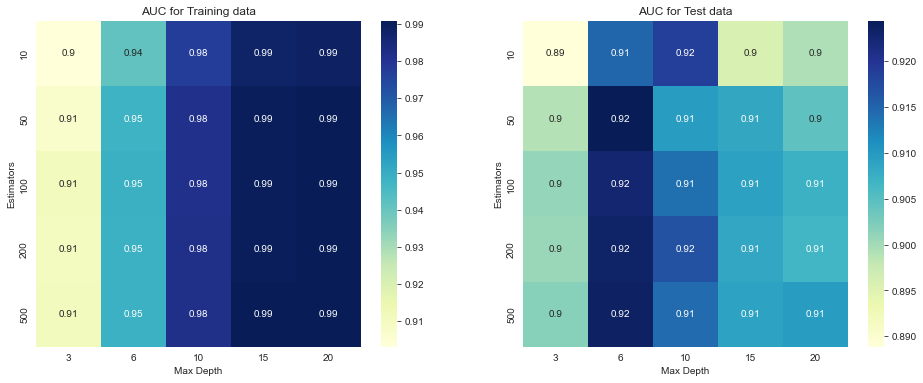

In [10]:
# plot the heatmap of AUC values for all possible combinations of n_estimators and max_depth values
# two heatmaps : one for train data and another for test data
max_depth_list = list(clf.cv_results_['param_max_depth'].data)
estimators_list = list(clf.cv_results_['param_n_estimators'].data)

sns.set_style("whitegrid")
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_train_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Training data')
plt.subplot(1,2,2)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_test_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="YlGnBu").set_title('AUC for Test data')
plt.show()

In [11]:
def plot_roc_curve(roc_auc_train, roc_auc_test):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_tr, tpr_tr, 'g', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_ts, tpr_ts, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

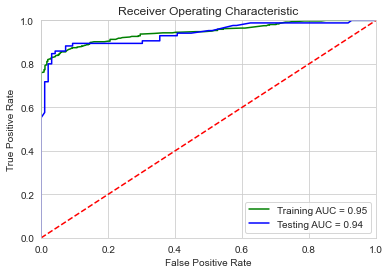

In [12]:
# make a Random Forest Classifier with the best values of the hyperparameters
# then plot the ROC curve

#Best hyper parameter 
clf = RandomForestClassifier(n_estimators=best_n_estimators_value, max_depth=best_max_depth_value)
clf.fit(train_features, train_targets)

y_pred_train = clf.predict_proba(train_features)[:,1]
y_pred_test = clf.predict_proba(test_features)[:,1]

   
#train data ROC
fpr_tr, tpr_tr, threshold = roc_curve(train_targets, y_pred_train)
roc_auc_train = auc(fpr_tr, tpr_tr)

#test data ROC
fpr_ts, tpr_ts, threshold = roc_curve(test_targets, y_pred_test)
roc_auc_test = auc(fpr_ts, tpr_ts)

#Plot ROC curve
plot_roc_curve(roc_auc_train, roc_auc_test)

In [13]:
acc_rf_grid = accuracy_score(test_targets, clf.predict(test_features))

print(acc_rf_grid)

0.8674033149171271


In [14]:
# Compare both the models using Prettytable library    
x = PrettyTable()

x.field_names = ["Model", "n_estimators", "max_depth","Accuracy"]

x.add_row(["Random Forest with GridSearch", best_n_estimators_value, best_max_depth_value, acc_rf_grid])

print(x)

+-------------------------------+--------------+-----------+--------------------+
|             Model             | n_estimators | max_depth |      Accuracy      |
+-------------------------------+--------------+-----------+--------------------+
| Random Forest with GridSearch |      50      |     6     | 0.8674033149171271 |
+-------------------------------+--------------+-----------+--------------------+


>1, train: 0.875, test: 0.867
>2, train: 0.893, test: 0.884
>3, train: 0.885, test: 0.878
>4, train: 0.883, test: 0.873
>5, train: 0.883, test: 0.884
>6, train: 0.878, test: 0.878
>7, train: 0.892, test: 0.862
>8, train: 0.875, test: 0.884
>9, train: 0.881, test: 0.878
>10, train: 0.881, test: 0.873
>11, train: 0.890, test: 0.878
>12, train: 0.888, test: 0.890
>13, train: 0.885, test: 0.878
>14, train: 0.885, test: 0.878
>15, train: 0.883, test: 0.873
>16, train: 0.895, test: 0.862
>17, train: 0.889, test: 0.867
>18, train: 0.888, test: 0.884
>19, train: 0.883, test: 0.884


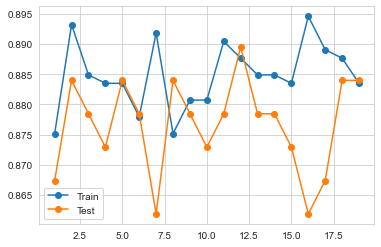

In [15]:
train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.2,
                                                                                  random_state=23)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 20)]

for i in values:
	# configure the model
	model = RandomForestClassifier(n_estimators=best_n_estimators_value, max_depth=best_max_depth_value).fit(
        train_features, train_targets)
	# evaluate on the train dataset
	schatting = model.predict(train_features)
	train_acc = accuracy_score(train_targets, schatting)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_schatting = model.predict(test_features)
	test_acc = accuracy_score(test_targets, test_schatting)
	test_scores.append(test_acc)
	# summarise progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()